In [8]:
!pip install yfinance textblob

**Load headlines and get NVDA daily prices**

In [9]:
import pandas as pd
from datetime import datetime
import yfinance as yf
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load and clean GDELT data

In [11]:

# Load scraped headline
data_path = "/content/drive/MyDrive/Project 2/NVIDIA_Merged_20241101-Present.csv"
df_news = pd.read_csv(data_path)
df_news.head()

,language,sourcecountry,seendate,date,url,title,domain,open,high,low,close,adj_close,volume
0,English,Australia,2024-11-18 03:45:00+00:00,2024-11-18,https://www.fool.com.au/2024/11/18/prediction-...,Prediction : Nvidia stock is going to soar aft...,fool.com.au,139.5,141.55,137.15,140.15,140.11,221205300
1,English,Cyprus,2024-11-18 04:00:00+00:00,2024-11-18,https://cyprus-mail.com/2024/11/18/softbank-fi...,SoftBank first to receive new Nvidia chips for...,cyprus-mail.com,139.5,141.55,137.15,140.15,140.11,221205300
2,English,China,2024-11-18 04:00:00+00:00,2024-11-18,https://www.morningstar.com/markets/this-unlov...,Why Small - Cap Value Stocks Look Attractive R...,morningstar.com,139.5,141.55,137.15,140.15,140.11,221205300
3,English,United States,2024-11-18 06:30:00+00:00,2024-11-18,https://247wallst.com/market-news/2024/11/17/n...,Nasdaq Futures Up Sunday Night : NVIDIA Earnin...,247wallst.com,139.5,141.55,137.15,140.15,140.11,221205300
4,English,United States,2024-11-18 11:00:00+00:00,2024-11-18,https://www.benzinga.com/24/11/42029943/dow-tu...,Dow Tumbles Over 300 Points Following Economic...,benzinga.com,139.5,141.55,137.15,140.15,140.11,221205300


In [12]:
# Make sure seendate is datetime
df_news["seendate"] = pd.to_datetime(df_news["seendate"], errors="coerce")
df_news = df_news.dropna(subset=["seendate"])

# Extract calendar date (YYYY-MM-DD) to align with stock data
df_news["date"] = df_news["seendate"].dt.date

print("Sample news rows:")
print(df_news.head(), "\n")
print("Total news rows:", len(df_news))

print("Total news rows:", len(df_news))

Sample news rows:
  language  sourcecountry                  seendate        date  \
0  English      Australia 2024-11-18 03:45:00+00:00  2024-11-18   
1  English         Cyprus 2024-11-18 04:00:00+00:00  2024-11-18   
2  English          China 2024-11-18 04:00:00+00:00  2024-11-18   
3  English  United States 2024-11-18 06:30:00+00:00  2024-11-18   
4  English  United States 2024-11-18 11:00:00+00:00  2024-11-18   

                                                 url  \
0  https://www.fool.com.au/2024/11/18/prediction-...   
1  https://cyprus-mail.com/2024/11/18/softbank-fi...   
2  https://www.morningstar.com/markets/this-unlov...   
3  https://247wallst.com/market-news/2024/11/17/n...   
4  https://www.benzinga.com/24/11/42029943/dow-tu...   

                                               title           domain   open  \
0  Prediction : Nvidia stock is going to soar aft...      fool.com.au  139.5   
1  SoftBank first to receive new Nvidia chips for...  cyprus-mail.com  139.5   
2 

Pull NVDA daily prices from Yahoo Finance

In [13]:
#Download NVDA Daily stock prices.

start = "2024-11-01"
end = "2025-11-02" #yfinance end is exculsive, so go one day past

df_price = yf.download("NVDA", start=start, end=end)
df_price = df_price.reset_index() #'Date' column

# Flatten MultiIndex columns if they exist
# For yfinance single ticker download, columns often become MultiIndex with ('Metric', 'Ticker')
# e.g., ('Close', 'NVDA') after reset_index(), ('Date', '') is also a tuple
if isinstance(df_price.columns, pd.MultiIndex):
    # Join the levels of the MultiIndex columns to create single-level column names
    df_price.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_price.columns]
    # Clean up column names, e.g., 'Close_NVDA' -> 'Close', 'Date_' -> 'Date'
    df_price.columns = [col.replace('_NVDA', '').replace('Date_', 'Date') for col in df_price.columns]

# Ensure 'date' column is created from the (now flattened) 'Date' column
df_price["date"] = df_price["Date"].dt.date

# Keep only the date + close price for now
# Now, 'Close' should be a single-level column name
df_price = df_price[["date", "Close"]]

print(df_price.head())
print("Number of trading days:", len(df_price))

/tmp/ipython-input-1768027.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_price = yf.download("NVDA", start=start, end=end)
[*********************100%***********************]  1 of 1 completed

         date       Close
0  2024-11-01  135.361191
1  2024-11-04  136.011002
2  2024-11-05  139.869888
3  2024-11-06  145.568268
4  2024-11-07  148.837341
Number of trading days: 250


Aggregate headlines to daily level before merging

In [14]:
# For each date, concatenate all titles into one big "document"
df_daily_news = (
    df_news
    .groupby("date")["title"]
    .apply(lambda titles: " ".join(str(t) for t in titles))
    .reset_index(name="titles_concat")
)

print(df_daily_news.head())
print("Number of days with at least one headline:", len(df_daily_news))


         date                                      titles_concat
0  2024-11-18  Prediction : Nvidia stock is going to soar aft...
1  2024-11-19  Investors Wait For Nvidia Earnings Nasdaq gain...
2  2024-11-20  Nvidia Q3 Earnings Preview : 9 % Stock Move Li...
3  2024-11-21  Nvidia third quarter earnings top expectations...
4  2024-11-22  Nvidia Stock Was Down Despite Its Amazing Earn...
Number of days with at least one headline: 241


Merge daily news with stock prices

In [15]:
# Merge on date – inner join keeps days that have both headlines and prices
df_merged = pd.merge(
    df_daily_news,
    df_price,
    on="date",
    how="inner"
)

print(df_merged.head())
print("Merged rows (days with both news & price):", len(df_merged))

         date                                      titles_concat       Close
0  2024-11-18  Prediction : Nvidia stock is going to soar aft...  140.109802
1  2024-11-19  Investors Wait For Nvidia Earnings Nasdaq gain...  146.967850
2  2024-11-20  Nvidia Q3 Earnings Preview : 9 % Stock Move Li...  145.848175
3  2024-11-21  Nvidia third quarter earnings top expectations...  146.627960
4  2024-11-22  Nvidia Stock Was Down Despite Its Amazing Earn...  141.909302
Merged rows (days with both news & price): 226


**Build daily TF_IDF features + simple sentiment**

Tf-idf on daily documents

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use all daily documents as corpus
corpus = df_merged["titles_concat"].fillna("")

# Build a TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,   # cap number of features for practicality
    stop_words="english" # remove common English words
)

# Fit on the full corpus and transform
X_tfidf = vectorizer.fit_transform(corpus)

# Turn sparse matrix into a DataFrame
tfidf_feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf_feature_names,
    index=df_merged.index
)

print("TF-IDF shape:", df_tfidf.shape)


TF-IDF shape: (226, 1000)


Add a simple sentiment score

In [17]:
def get_sentiment(text):
    if not isinstance(text, str):
        return 0.0
    return TextBlob(text).sentiment.polarity  # between -1 (negative) and +1 (positive)

df_merged["sentiment"] = df_merged["titles_concat"].apply(get_sentiment)

print(df_merged[["date", "sentiment"]].head())


         date  sentiment
0  2024-11-18   0.160994
1  2024-11-19   0.137362
2  2024-11-20   0.101694
3  2024-11-21   0.125801
4  2024-11-22   0.141293


Combine everthing into a modeling DataFrame

In [18]:
#Combine original daily merged data and TF-IFP features
df_model = pd.concat(
    [df_merged[["date", "Close", "sentiment"]], df_tfidf],
    axis=1
)
print(df_model.head())
print("Final feature table shape:", df_model.shape)

         date       Close  sentiment        00       000        10  100   11  \
0  2024-11-18  140.109802   0.160994  0.000000  0.000000  0.000000  0.0  0.0   
1  2024-11-19  146.967850   0.137362  0.000000  0.022203  0.000000  0.0  0.0   
2  2024-11-20  145.848175   0.101694  0.029731  0.028030  0.000000  0.0  0.0   
3  2024-11-21  146.627960   0.125801  0.032303  0.000000  0.000000  0.0  0.0   
4  2024-11-22  141.909302   0.141293  0.000000  0.025588  0.077592  0.0  0.0   

   118        12  ...  worth      wrap  wrong       xai   xi      year  \
0  0.0  0.000000  ...    0.0  0.000000    0.0  0.000000  0.0  0.000000   
1  0.0  0.000000  ...    0.0  0.029534    0.0  0.000000  0.0  0.021853   
2  0.0  0.000000  ...    0.0  0.037284    0.0  0.000000  0.0  0.013794   
3  0.0  0.026878  ...    0.0  0.020255    0.0  0.034998  0.0  0.014987   
4  0.0  0.090334  ...    0.0  0.000000    0.0  0.000000  0.0  0.050369   

      years    yields  youd      zone  
0  0.000000  0.049339   0.0  0.049

Create next-day target and final X,y

In [19]:
#Sort by date to respect time order
df_model = df_model.sort_values("date").reset_index(drop=True)

#Create next_day close as target
df_model["close_next"] = df_model["Close"].shift(-1)

#Optional: next-day return
df_model["return_next"] = (df_model["close_next"]-df_model["Close"]) / df_model["Close"]

#Drop the last row (no next-day info)
df_model = df_model.dropna(subset=["close_next"])

print(df_model[["date","Close", "close_next","return_next"]].head())


         date       Close  close_next  return_next
0  2024-11-18  140.109802  146.967850     0.048948
1  2024-11-19  146.967850  145.848175    -0.007619
2  2024-11-20  145.848175  146.627960     0.005347
3  2024-11-21  146.627960  141.909302    -0.032181
4  2024-11-22  141.909302  135.981003    -0.041775


 EXTRACT X, y FOR MODELING

In [20]:
feature_cols = ["sentiment"] + list(tfidf_feature_names) +[ "Close"] #include today's Close as a feature
X = df_model[feature_cols].values           # features (for MLP or to build sequences)
y_price = df_model["close_next"].values     # predict next-day price
y_return = df_model["return_next"].values     # (or) predict next-day return

print("X shape:", X.shape)
print("y_price shape:", y_price.shape)
print("y_return shape:", y_return.shape)


X shape: (225, 1004)
y_price shape: (225,)
y_return shape: (225,)


In [21]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Get features and do time-aware split

In [22]:
df_model = df_model.sort_values("date").reset_index(drop=True)
feature_cols = [ "Close", "sentiment"] + list(tfidf_feature_names)

X = df_model[feature_cols].values.astype(np.float32)
y = df_model["close_next"].values.astype(np.float32)

n = len(df_model)
train_end = int(0.7*n)
val_end = int(0.85*n)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

# Scale features: fit on train, transform val/test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape)   # (n_samples, n_features)


X_train shape: (157, 1004)


In [23]:
from sklearn.decomposition import PCA

# Reduce to, say, 50 dimensions (you can also try 30, 100, etc.)
pca = PCA(n_components=50, random_state=42)

X_train = pca.fit_transform(X_train)
X_val   = pca.transform(X_val)
X_test  = pca.transform(X_test)

print("X_train (after PCA) shape:", X_train.shape)  # should be (n_samples, 50)


X_train (after PCA) shape: (157, 50)


**MLP model (single-day feature -> next day return)**

Build PyTorch datasets & Loader

In [24]:
batch_size = 32

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,  shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

Define MLP regressor

In [25]:
class MLPRegressor(nn.Module):
  def __init__(self, input_dim, hidden1=32, hidden2=15, dropout=0.1):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input_dim, hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden2,1)
    )
  def forward(self, x):
    return self.net(x)
input_dim = X_train.shape[1]
mlp_model = MLPRegressor(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3, weight_decay=1e-4)   # try 1e-4 first, maybe 1e-5 also

Train loop for MLP

In [26]:
def evaluate_model(model, dataloader):
  model.eval()
  total_loss = 0
  n_samples = 0 # Initialize n_samples here
  with torch.no_grad():
    for X_batch, y_batch in dataloader:
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      preds = model(X_batch)
      loss = criterion(preds, y_batch)

      batch_size = y_batch.size(0)
      total_loss += loss.item() * batch_size
      n_samples += batch_size

  return np.sqrt(total_loss / n_samples) # RMSE

num_epochs = 200
patience = 10
best_val_rmse = float('inf')
best_state_dict = None
epochs_without_improvement = 0

for epoch in range(1, num_epochs+1):
  mlp_model.train()
  total_train_loss = 0
  n_train = 0

  for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    preds = mlp_model(X_batch)
    loss = criterion(preds, y_batch)
    loss.backward()
    optimizer.step()

    batch_size = y_batch.size(0)
    total_train_loss += loss.item() * batch_size
    n_train += batch_size

  train_rmse = np.sqrt(total_train_loss / n_train)
  val_rmse = evaluate_model(mlp_model, val_loader)

  if epoch % 5 == 0 or epoch == 1:
    print(f"Epoch {epoch:3d} | Train RMSE: {train_rmse:.6f} | Val RMSE: {val_rmse:.6f}")

  #Early Stopping Logic
  if val_rmse < best_val_rmse - 1e-4:   #small tolerance to avoid noise
    best_val_rmse = val_rmse
    best_state_dict = mlp_model.state_dict()
    epochs_without_improvement = 0

  else:
    epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
      print(f"Early stopping triggered at epoch {epoch}.")
      break

#restore best model weights
if best_state_dict is not None:
  mlp_model.load_state_dict(best_state_dict)
  print(f"Loaded best model wiwth Val RMSE = {best_val_rmse: .6f}")

Epoch   1 | Train RMSE: 132.318882 | Val RMSE: 177.219392
Epoch   5 | Train RMSE: 131.606991 | Val RMSE: 176.775486
Epoch  10 | Train RMSE: 130.342963 | Val RMSE: 175.885827
Epoch  15 | Train RMSE: 128.287914 | Val RMSE: 174.377740
Epoch  20 | Train RMSE: 124.801995 | Val RMSE: 171.918446
Epoch  25 | Train RMSE: 119.168247 | Val RMSE: 168.143679
Epoch  30 | Train RMSE: 110.927099 | Val RMSE: 162.639480
Epoch  35 | Train RMSE: 101.214387 | Val RMSE: 155.059576
Epoch  40 | Train RMSE: 87.328830 | Val RMSE: 145.015225
Epoch  45 | Train RMSE: 70.109354 | Val RMSE: 132.899863
Epoch  50 | Train RMSE: 52.258781 | Val RMSE: 120.353213
Epoch  55 | Train RMSE: 41.666942 | Val RMSE: 109.845939
Epoch  60 | Train RMSE: 34.201133 | Val RMSE: 102.800041
Epoch  65 | Train RMSE: 29.055367 | Val RMSE: 99.928021
Epoch  70 | Train RMSE: 27.959047 | Val RMSE: 98.412489
Epoch  75 | Train RMSE: 26.301137 | Val RMSE: 98.213129
Epoch  80 | Train RMSE: 24.199594 | Val RMSE: 98.110652
Epoch  85 | Train RMSE: 25.

In [27]:
mlp_model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = mlp_model(X_batch).cpu().numpy().ravel()
        all_preds.append(preds)
        all_true.append(y_batch.numpy().ravel())

y_pred_test = np.concatenate(all_preds)   # predicted next-day close
y_true_test = np.concatenate(all_true)    # true next-day close

test_dates = df_model["date"].values[val_end:]   # same slice as X_test / y_test


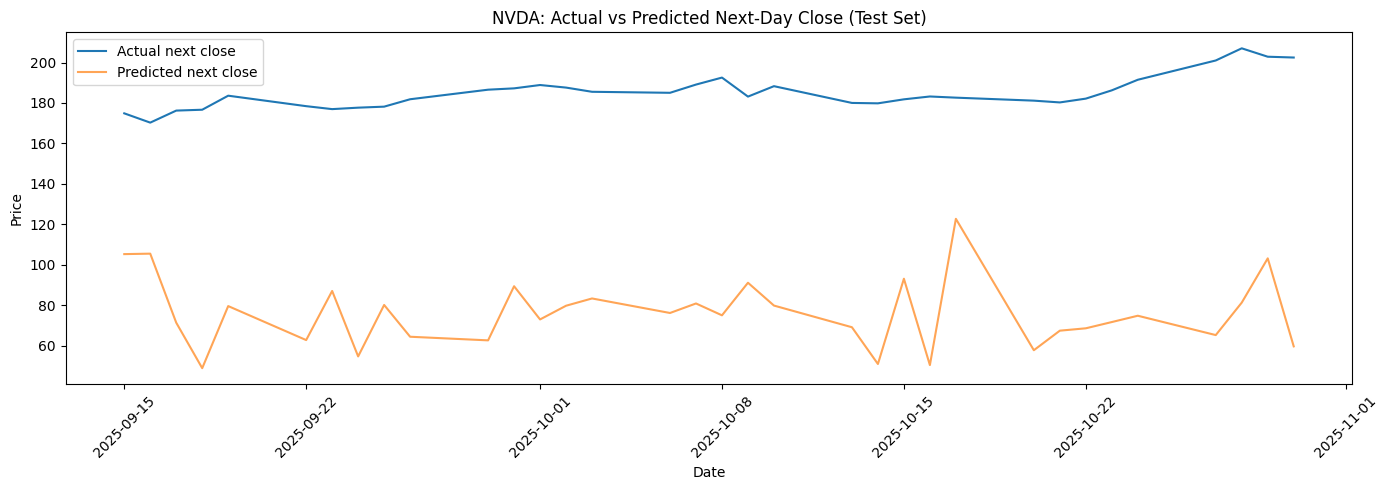

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true_test, label="Actual next close")
plt.plot(test_dates, y_pred_test, label="Predicted next close", alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("NVDA: Actual vs Predicted Next-Day Close (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


Test Performance

In [29]:
test_rmse = evaluate_model(mlp_model, test_loader)
print(f"MLP Test RMSE (on next-day return): {test_rmse:.6f}")

MLP Test RMSE (on next-day return): 110.581256


In [30]:
# ----- Baseline: always predict the mean of y_train -----
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32)

y_train_mean = y_train_tensor.mean().item()

with torch.no_grad():
    baseline_preds = torch.full_like(y_val_tensor, y_train_mean)
    baseline_mse = torch.mean((baseline_preds - y_val_tensor) ** 2).item()
    baseline_rmse = baseline_mse ** 0.5

print(f"Baseline RMSE (predicting train mean): {baseline_rmse:.6f}")
print(f"MLP best Val RMSE: {best_val_rmse:.6f}")


Baseline RMSE (predicting train mean): 46.195687
MLP best Val RMSE: 97.109242
